In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 17, 'figure.figsize': [15, 7]})
FIGSIZE = (15, 7)

### Constants
Here we define all constants that we will re-derive throughout the notebook.

In [24]:
PRICING_FACTOR = 0.16004493105825985
PRICING_NO_BATTERY = 0.1889893403857968
EMISSION_NO_BATTERY = 0.10565039720688782
RAMPING_FACTOR = 0.7515799770633255 #  = 0.3380755161315769 / 0.4498197483287821 = original sum * correction factor
RAMPING_NO_BATTERY = 0.3380755161315768
LOAD_FACTOR = 84.4161565292503
LOAD_NO_BATTERY = 1.9857512502718446e-05
NET_CONS_MEDIAN = np.array([3.058308333396912, 2.7347333333333337, 2.309199999999999, 2.251299998537699, 4.265708333333334, 4.738175002503395, 3.7384416666666667, 2.4427625308740746, 1.8897083458503086, 2.150258333309492, 2.4845249979654946, 3.7908958333333325])
NET_CONS_MAX_ABV_MEDIAN = np.array([10.774841668269756, 13.983000000254311, 11.003333387447917, 9.412916668128972, 7.8483583333333335, 10.557608330829936, 7.527108333333334, 10.917187469125928, 7.106424987483024, 11.542174983747802, 12.195541668701171, 12.267887508265177])

## Price term
We start with the term as it's defined:

In [25]:
pricing = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/pricing.csv")
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
district_price = net_consumption.sum(axis=1).clip(lower=0) * pricing['Electricity Pricing [$]']

p0 = sum(district_price) / (365 * 24 * 5) / PRICING_NO_BATTERY
print(f"p0 = {p0}")

p0 = 1.0


Now we define an alternative loss that will be equivalent to the previous one.

The issue is that the formal utility definition requires taking subplus (relu) of the total district net consumption. This is not possible in the evaluation of a single building. Therefore, we will use an alternative instantaneous utility.

We will wrap it into a function that will take the net consumption and return the instantaneous $\frac{P_+}{P_-}$ term. Then we will show it is summed to 1 for no-op agent (pure net consumption).

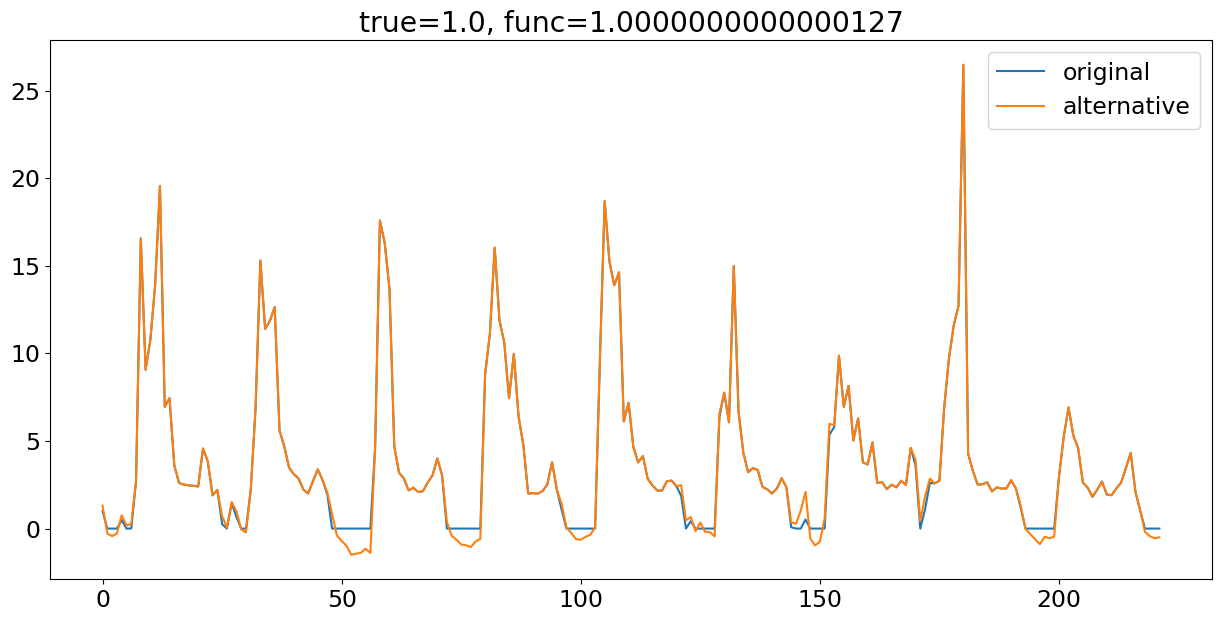

In [26]:
def pricing_term(net_cons, prc):
    """
    net_cons: net consumption of one building in kWh
    carbon_ints: carbon_intensity['kg_CO2/kWh']
    """
    positive_part = np.maximum(net_cons, 0) * prc
    negative_part = np.minimum(net_cons, 0) * prc * PRICING_FACTOR
    return (positive_part + negative_part) / PRICING_NO_BATTERY

pricing = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/pricing.csv")
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
pricing_u = pd.DataFrame(pricing_term(net_consumption.to_numpy(copy=True), np.reshape(pricing['Electricity Pricing [$]'].to_numpy(copy=True), (-1, 1))))
pricing_u_sum = pricing_u.sum(axis=1).to_numpy(copy=True)

plt.figure()
plt.plot(range(222), district_price[2000:2222] / PRICING_NO_BATTERY, label="original")
plt.plot(range(222), pricing_u_sum[2000:2222], label="alternative")
plt.title('true=' + str(p0) + ', func=' + str(np.mean(pricing_u.to_numpy().flatten())))
plt.legend()
plt.show()

## Carbon emission term
We start with the term as it's defined:

In [27]:
carbon_intensity = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/carbon_intensity.csv")
net_consumption_clipped = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv").clip(lower=0)

c0 = sum(net_consumption_clipped.sum(axis=1) * carbon_intensity['kg_CO2/kWh']) / (365 * 24 * 5) / EMISSION_NO_BATTERY
print(f"c0 = {c0}")

c0 = 1.0


Now we define an alternative loss that will be equivalent to the previous one.

Here we don't have the total-district-subplus issue, as we take the positive part of each building's net consumption anyway.

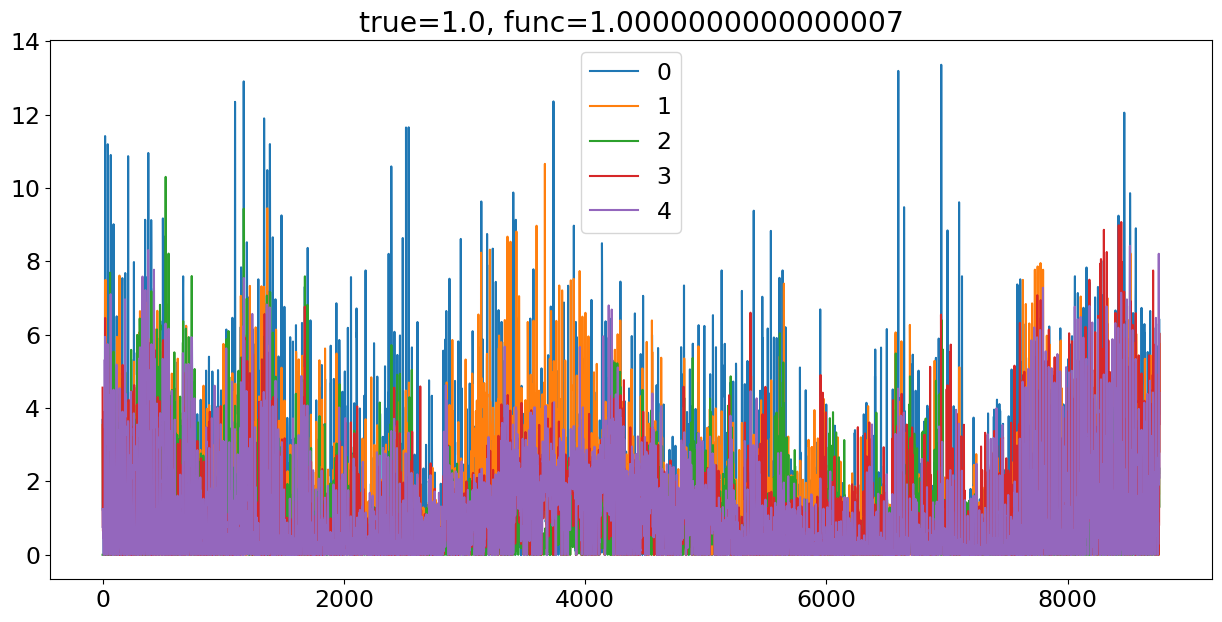

In [28]:
def carbon_intensity_term(net_cons, carbon_ints):
    """
    net_cons: net consumption of one building in kWh
    carbon_ints: carbon_intensity['kg_CO2/kWh']
    """
    return np.maximum(net_cons, 0) * carbon_ints / EMISSION_NO_BATTERY

carbon_intensity = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/carbon_intensity.csv")
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
carbon_ints_u = pd.DataFrame(carbon_intensity_term(net_consumption.to_numpy(copy=True), np.reshape(carbon_intensity['kg_CO2/kWh'].to_numpy(copy=True), (-1, 1))))
carbon_ints_u.plot()
plt.title('true=' + str(c0) + ', func=' + str(np.mean(carbon_ints_u.to_numpy().flatten())))
plt.show()

## Ramping term

In [29]:
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption['sum'] = net_consumption.sum(axis=1)
net_consumption['abs diff'] = abs(net_consumption['sum'].diff().fillna(0))
net_consumption.head()

,Building_0,Building_1,Building_2,Building_3,Building_4,sum,abs diff
0,2.275800,2.188750,1.009623e-07,2.819150,0.771433,8.055133,0.000000
1,0.851167,1.370667,1.018524e-07,1.928167,0.515883,4.665883,3.389250
2,0.834600,1.101250,1.008352e-07,0.475817,0.503050,2.914717,1.751167
3,0.838167,0.543217,1.007080e-07,0.458233,0.535950,2.375567,0.539150
4,1.478433,0.542833,1.015981e-07,0.446017,0.512617,2.979900,0.604333


The sum abs of this diff should be taken and divided by 5 (buildings) and 365*24 (hours) to get the average power consumption per building per hour.

In [30]:
r0 = sum(net_consumption['abs diff']) / (365 * 24 * 5) / RAMPING_NO_BATTERY
print(f"r0 = {r0}")

r0 = 1.0


This is the value by which each delta net consumption should be normalized by to get the approximation for instantaneous $\frac{R_+}{R_-}$ term.

Now we will wrap this into a function that will take a dataframe with the net consumption and return the instantaneous $\frac{R_+}{R_-}$ term. Then we will show it is summed to 1.

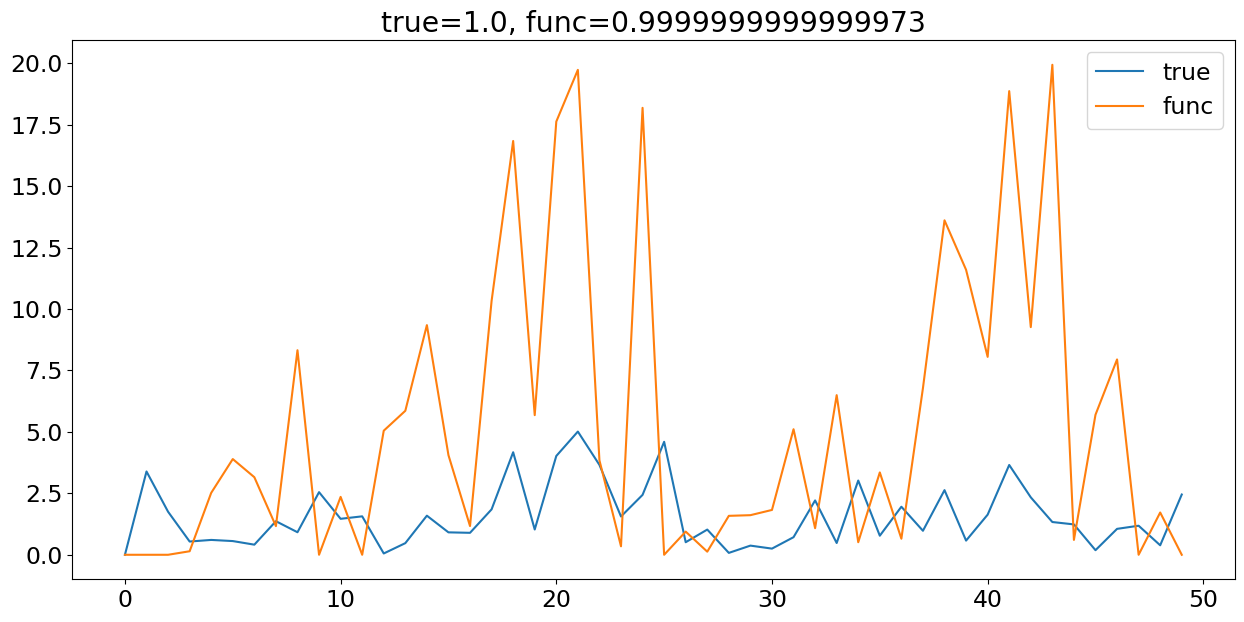

In [31]:
def ramping_term(consumption_diff):
    """
    consumption_diff:net consumption diff kWh/h of one building
    """
    # return np.abs(consumption_diff) / RAMPING_FACTOR
    return np.maximum(consumption_diff, np.zeros_like(consumption_diff)) / RAMPING_FACTOR / RAMPING_NO_BATTERY

net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption_diff = net_consumption.diff().fillna(0).to_numpy(copy=True)
net_consumption['sum'] = net_consumption.sum(axis=1)                          #   remove later
net_consumption['abs diff'] = abs(net_consumption['sum'].diff().fillna(0))    #   remove later
inst_u_ramping_term = pd.DataFrame(ramping_term(net_consumption_diff))
inst_u_ramping_term['sum'] = inst_u_ramping_term.sum(axis=1)

plt.plot(net_consumption['abs diff'].iloc[:50], label='true')
plt.plot(inst_u_ramping_term['sum'].iloc[:50], label='func')
plt.legend()
plt.title('true=' + str(r0) + ', func=' + str(np.mean(inst_u_ramping_term['sum'] / 5)))
plt.show()

## Load term
We start with the term as it's defined:

In [32]:
window = 730
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption_sum = pd.DataFrame().assign(net_electricity_consumption=net_consumption.sum(axis=1))
net_consumption_sum['group'] = (net_consumption_sum.index/window).astype(int)
net_consumption_grouped = net_consumption_sum.groupby(['group'])[['net_electricity_consumption']].agg(['mean','max','median'])
net_consumption_grouped['load_factor'] = 1 - (net_consumption_grouped[('net_electricity_consumption','mean')]/net_consumption_grouped[('net_electricity_consumption','max')])
net_consumption_grouped['load_factor'] = net_consumption_grouped['load_factor'].rolling(window=net_consumption_grouped.shape[0],min_periods=1).mean()

net_consumption_grouped.head(6)

net_electricity_consumption                      load_factor
                             mean        max    median            
group                                                             
0                        2.863414  13.833150  3.058308    0.793003
1                        2.068934  16.717733  2.734733    0.834623
2                        1.262841  13.312533  2.309200    0.858129
3                        1.228048  11.664217  2.251300    0.867276
4                        3.347303  12.114067  4.265708    0.838557
5                        4.068800  15.295783  4.738175    0.821130

In [33]:
net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption_np = net_consumption.sum(axis=1).to_numpy(copy=True)
max_vec = np.array(NET_CONS_MAX_ABV_MEDIAN + NET_CONS_MEDIAN).repeat(730)
true_L = (1 - (net_consumption_np / max_vec)) / (365 * 24)  # we absorb the (365 * 24) factor into L as only here they chose to take the mean rather than the sum
l0 = np.sum(true_L) / (365 * 24 * 5) / LOAD_NO_BATTERY
print(l0)

1.0


Now we define an alternative loss that will be equivalent to the previous one, but only for the sum.
It will use the exponent of cropped above median/5 (buildings) values to steer the consumption away from reaching a new monthly peak, where we introduce the penalty only for values above the median.

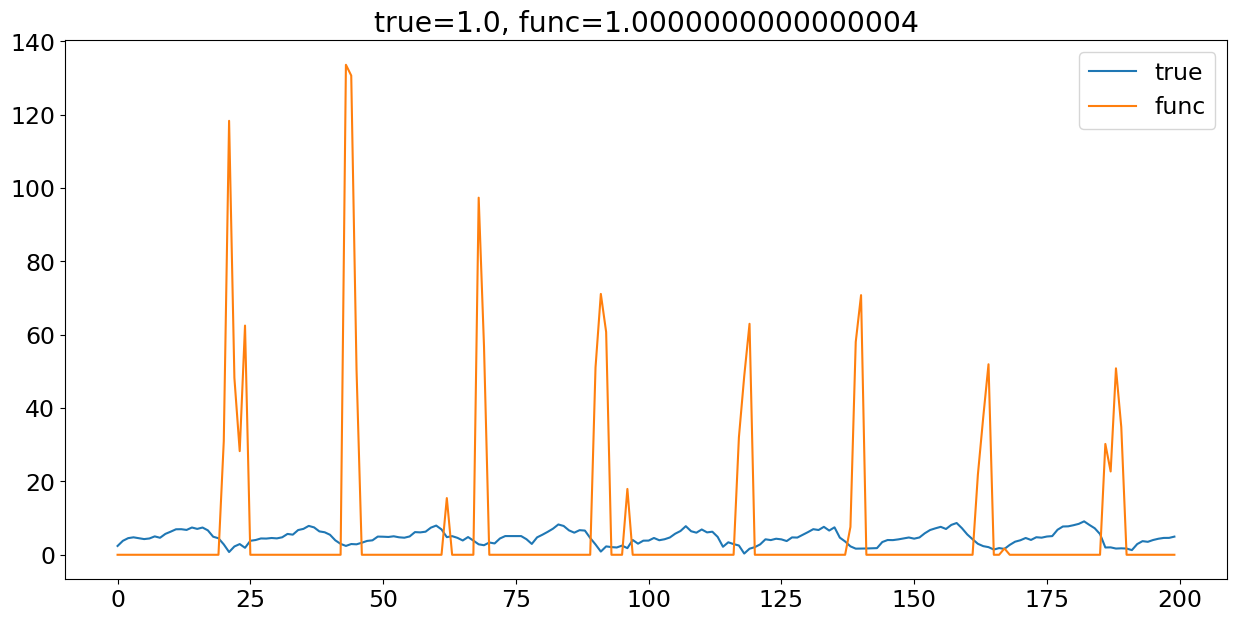

In [34]:
def load_term(net_cons, month):
    """net_cons: net consumption of one building in kWh
    month: month of the year (0-11), given as hour of the year (0-8759)//730
    """
    net_cons_above_median = net_cons - NET_CONS_MEDIAN[month]
    return (np.exp(net_cons_above_median.clip(min=0) / NET_CONS_MAX_ABV_MEDIAN[month]) - 1) / LOAD_FACTOR / LOAD_NO_BATTERY

load_inst_u = pd.DataFrame(load_term(net_consumption.to_numpy(copy=True), np.reshape(np.arange(8760) // 730, (-1, 1))))
load_inst_u_sum = load_inst_u.sum(axis=1).to_numpy(copy=True)
plt.figure()
plt.plot(range(200), true_L[:200] / LOAD_NO_BATTERY, label='true')
plt.plot(range(200), load_inst_u_sum[:200], label='func')
plt.title('true=' + str(l0) + ', func=' + str(np.mean(load_inst_u_sum) / 5))
plt.legend()
plt.show()

## Total utility
According to the original weighting, we define the instantaneous utility as:

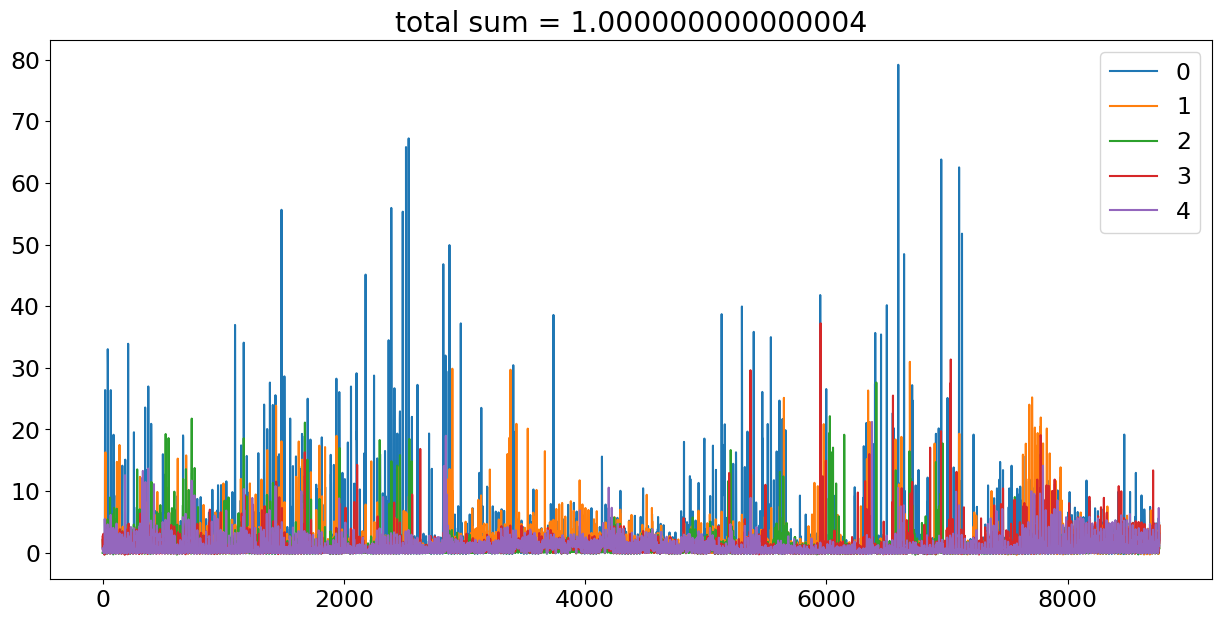

In [37]:
def inst_u(net_cons, consumption_diff, prc, carbon_ints, month):
    """
    net_cons: net consumption of one building in kWh
    consumption_diff: difference between the net consumption and the previous net consumption
    prc: pricing['Electricity Pricing [$]']
    carbon_ints: carbon_intensity['kg_CO2/kWh']
    month: month of the year (0-11), given as hour of the year (0-8759)//730
    """
    return (2 * pricing_term(net_cons, prc) + 2 * carbon_intensity_term(net_cons, carbon_ints) + ramping_term(consumption_diff) + load_term(net_cons, month)) / 6

net_consumption = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption_diff = net_consumption.diff().fillna(0).to_numpy(copy=True)
pricing = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/pricing.csv")
carbon_intensity = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/carbon_intensity.csv")

total_inst_u = pd.DataFrame(inst_u(net_consumption.to_numpy(copy=True), net_consumption_diff, np.reshape(pricing['Electricity Pricing [$]'].to_numpy(copy=True), (-1, 1)), np.reshape(carbon_intensity['kg_CO2/kWh'].to_numpy(copy=True), (-1, 1)), np.reshape(np.arange(8760) // 730, (-1, 1))))
total_inst_u.plot()
plt.title('total sum = ' + str(np.mean(total_inst_u.to_numpy().flatten())))
plt.show()